# GoogLeNet - Going Deep with Convolutions

## 1. Architecture
- ![arch2](https://user-images.githubusercontent.com/25279765/35002702-d5dccb60-fb2d-11e7-88ac-e29d0319f32b.png)
- 빨간색 동그라미가 쳐져있는 부분은 Inception 모듈을 사용한 곳입니다.
- 네트워크의 얕은 부분, 입력과 가까운 부분에는 Inception 모듈을 사용하지 않았다는 것입니다. 논문에 따르면 이 부분에는 Inception의 효과가 없었다고 합니다. 따라서 우리가 일반적으로 CNN하면 떠올리는, Conv와 Pooling 연산을 수행합니다.
- softmax를 통해 결과를 뽑아내는 부분이 맨 끝에만 있는 것이 아니라, 중간 중간에 있다는 점입니다. 이를 논문에서는 auxiliary classifier라고 부릅니다. 엄청나게 깊은 네트워크에서 Vanishing Gradient 문제를 걱정하지 않을 수 없죠. 그래서 auxiliary classifier를 덧붙인 겁니다. Loss를 맨 끝뿐만 아니라 중간 중간에서 구하기 때문에 gradient가 적절하게 역전파된다고 합니다. 대신 지나치게 영향을 주는 것을 막기 위해 auxiliary classifier의 loss는 0.3을 곱했습니다. 물론 실제로 테스트하는 과정에서는 auxiliary classifier를 제거하고 맨 끝, 제일 마지막의 softmax만을 사용하구요.
- ![architecture](http://img1.daumcdn.net/thumb/R1920x0/?fname=http%3A%2F%2Fcfile21.uf.tistory.com%2Fimage%2F995C60355ADFDDDB23007E)
- GAP의 이점은, 바로 학습 과정이 필요하지 않다는 점입니다. 이는 GAP가 어디까지나 풀링 과정에 지나지 않기 때문에 생겨납니다. 풀링은 학습과정이 아니기 때문에, 어떠한 패러미터도 추가로 발생하지 않습니다. 위의 표를 보시더라도, average pooling에 의해서 네트워크의 depth는 증가하지 않았습니다.

### (1) Auxiliary Classifier
-  Auxiliary Classifier는 깊은 네트워크의 학습에 대한 우려에 의해 추가되었습니다.
- 총 두번의 Auxiliary classification이 합쳐져 신경망 학습이 이루어집니다.
- 이 Auxiliary classifier는 어디까지나 학습의 용이를 위해 마련되었으므로, 학습이 완료된 후엔 네트워크에서 삭제됩니다. 학습과정에서만 존재할 수 있는 계층인 것이죠.
- There are some intermediate softmax branches at the middle. These branches are auxiliary classifiers which consist of
5x5 Average Pooling (stride 3), 1x1 Conv (128 filter), 1024 FC, 1000 FC, Softmax.
- The loss is added to the total loss, with weight 0.3.
- It is for combating gradient vanishing problem.
- It is not Used in testing time.

### (2) Inception Module
- Inception module is to have different sizes/types of convolutions for the same input and stacking all the outputs.
- 1×1 convolution is used as a dimension reduction module to reduce the computation. By reducing the computation bottleneck, depth and width can be increased.
- Inception module can be built without increasing the number of operations largely compared the one without 1×1 convolution.

### (3) Global Average Pooling
- A move from FC layers to average pooling improved the top 1 accuracy by about 0.6

In [4]:
from google.colab import drive
import os
import sys
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, Add, Dot, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input, Model, Sequential
from sklearn.model_selection import train_test_split

drive.mount("/content/drive", force_remount=True)
try:
    my_path = "/content/notebooks"
    os.symlink("/content/drive/MyDrive/ColabNotebooks/my_env", my_path)
    sys.path.insert(0, my_path)
except:
    pass
os.chdir(my_path)

def set_css():
  display(HTML("""
  <style>
    pre {white-space: pre-wrap;}
  </style>
  """))
get_ipython().events.register("pre_run_cell", set_css)

plt.style.use("dark_background")

Mounted at /content/drive


In [20]:
(x_tr, y_tr), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# y_tr = tf.keras.utils.to_categorical(y_tr)
# y_test = tf.keras.utils.to_categorical(y_test)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, train_size=0.8, shuffle=True, random_state=777)

print(x_tr.shape, y_tr.shape)

gen = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range = 0.2, horizontal_flip=True)

(40000, 32, 32, 3) (40000, 1)


In [26]:
def inception(x, filters): 
    f1, f2, f3, f4 = filters

    # 1x1
    conv1 = Conv2D(filters=f1, kernel_size=1, padding="same", activation="relu")(x)
    # 1x1 & 3x3
    conv2 = Conv2D(filters=f4, kernel_size=1, padding="same", activation="relu")(x)
    conv2 = Conv2D(filters=f2, kernel_size=3, padding="same", activation="relu")(conv2)
    # 1x1 & 5x5
    conv3 = Conv2D(filters=f4, kernel_size=1, padding="same", activation="relu")(x)
    conv3 = Conv2D(filters=f3, kernel_size=5, padding="same", activation="relu")(conv3)
    # pooling & 1x1
    max_pool = MaxPool2D(pool_size=3, strides=1, padding="same")(x)
    max_pool = Conv2D(filters=f4, kernel_size=1, padding="same", activation="relu")(max_pool)

    concat = Concatenate(axis=-1)([conv1, conv2, conv3, max_pool])
    
    return concat

input_shape = x_tr[0].shape
inputs = Input(shape=input_shape)

# conv랑 batch 사이에 max pooling 들어가야 하나, cifar 데이터에선 크기 너무 줄어들어서 뺐음
z = Conv2D(filters=64, kernel_size=7, strides=2, padding="same", activation="relu")(inputs)
# z = MaxPool2D(pool_size=3, strides=2, padding="same"(z)
z = BatchNormalization()(z)
z = Conv2D(filters=192, kernel_size=3, padding="same", activation="relu")(z)
# z = MaxPool2D(pool_size=3, strides=2, padding="same"(z)
z = BatchNormalization()(z) 
# inception 3a
z = inception(z, [64, 128, 32, 32])
# inception 3b
z = inception(z, [128, 192, 96, 64])
z = MaxPool2D(pool_size=3, strides=2, padding="same")(z)
# inception 4a
z = inception(z, [192, 208, 48, 64])
# Auxiliary Classifier
aux1 = AveragePooling2D(pool_size=5, strides=3, padding="valid")(z)
aux1 = Conv2D(filters=128, kernel_size=1, padding="same", activation="relu")(aux1)
aux1 = Flatten()(aux1)
aux1 = Dense(units=512, activation="relu")(aux1)
aux1 = Dense(units=10, activation="softmax")(aux1)
# inception 4b
z = inception(z, [160, 224, 64, 64])
# inception 4c
z = inception(z, [128, 256, 64, 64])
# inception 4d
z = inception(z, [112, 288, 64, 64])
# Auxiliary Classifier
aux2 = AveragePooling2D(pool_size=5, strides=3, padding="valid")(z)
aux2 = Conv2D(128, kernel_size=1, padding="same", activation="relu")(aux2)
aux2 = Flatten()(aux2)
aux2 = Dense(units=832, activation="relu")(aux2)
aux2 = Dense(units=10, activation="softmax")(aux2)
# inception 4e
z = inception(z, [256, 320, 128, 128])
z = MaxPool2D(pool_size=3, strides=2, padding="same")(z)
# inception 5a
z = inception(z, [256, 320, 128, 128])
# inception 5b
z = inception(z, [384, 384, 128, 128])
z = GlobalAveragePooling2D()(z)
# pool_size=(4,4), padding="valid")(x)
z = Dropout(rate=0.4)(z)
z = Flatten()(z)

outputs = Dense(units=10, activation="softmax", name="outputs")(z)

model = Model(inputs=inputs, outputs=[aux1, aux2, outputs])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", loss_weights=[0.3, 0.3, 1],
              metrics=["sparse_categorical_accuracy"]) 

model.summary()

es = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=2)
model_path = "GoogLeNet_cifar10.h5"
mc = ModelCheckpoint(filepath=model_path, monitor="val_outputs_sparse_categorical_accuracy", mode="auto", verbose=1,
                     save_best_only=True)
hist = model.fit(x=gen.flow(x_tr, y_tr, batch_size=32), validation_data=gen.flow(x_val, y_val, batch_size=32),
                 epochs=20, callbacks=[es, mc])

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_926 (Conv2D)             (None, 16, 16, 64)   9472        input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 16, 16, 64)   256         conv2d_926[0][0]                 
__________________________________________________________________________________________________
conv2d_927 (Conv2D)             (None, 16, 16, 192)  110784      batch_normalization_32[0][0]     
___________________________________________________________________________________________

Text(0.5, 1.0, 'Training and Validation Loss')

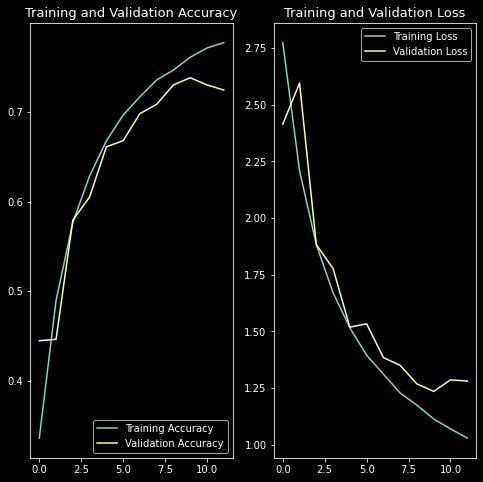

In [29]:
epochs = 12
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.plot(range(epochs), hist.history["outputs_sparse_categorical_accuracy"], label="Training Accuracy")
ax1.plot(range(epochs), hist.history["val_outputs_sparse_categorical_accuracy"], label="Validation Accuracy")
ax1.legend(loc="lower right")
ax1.set_title("Training and Validation Accuracy", size=13)

ax2.plot(range(epochs), hist.history["loss"], label="Training Loss")
ax2.plot(range(epochs), hist.history["val_loss"], label="Validation Loss")
ax2.legend(loc="upper right")
ax2.set_title("Training and Validation Loss", size=13)

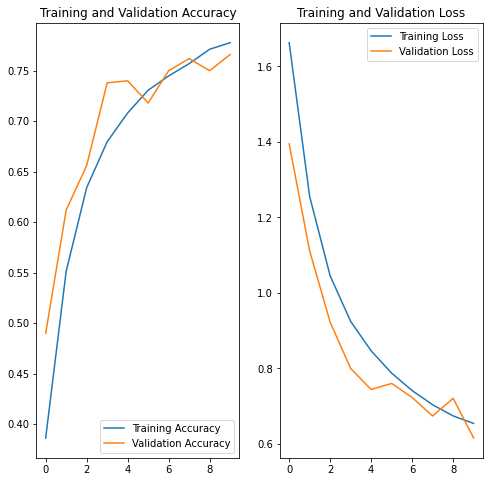

In [ ]:
# import matplotlib.pyplot as plt

# acc = history.history["dense_4_accuracy"]
# val_acc = history.history["val_dense_4_accuracy"]

# loss = history.history["dense_4_loss"]
# val_loss = history.history["val_dense_4_loss"]

# epochs_range = range(10)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc,  label="Training Accuracy")
# plt.plot(epochs_range, val_acc, label="Validation Accuracy")
# plt.legend(loc="lower right")
# plt.title("Training and Validation Accuracy")

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label="Training Loss")
# plt.plot(epochs_range, val_loss, label="Validation Loss")
# plt.legend(loc="upper right")
# plt.title("Training and Validation Loss")
# plt.show()